In [1]:
# Install Earth Engine + geemap
!pip -q install earthengine-api geemap

import ee, geemap

# Authenticate (follow the link that pops up and paste the token back)
ee.Authenticate()

# Initialize with your GEE project
ee.Initialize(project='ee-marina-kilifi')

print("✅ Google Earth Engine initialized for project: ee-marina-kilifi")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:00
✅ Google Earth Engine initialized for project: ee-marina-kilifi


In [2]:
# Step 2: Define Kilifi AOI (same as JS script geometry)
kilifi_geometry = ee.Geometry.Polygon(
    [[[39.742974618206986, -3.5638416823223396],
      [39.742974618206986, -3.700894870066225],
      [39.932488778363236, -3.700894870066225],
      [39.932488778363236, -3.5638416823223396]]],
    None, False
)

print("✅ AOI for Kilifi set.")


✅ AOI for Kilifi set.


In [3]:
# Step 3: Load Global Mangrove Watch datasets

# Historical mangrove extent (vector)
extent_1996 = ee.FeatureCollection(
    "projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/extent/gmw_v3_1996_vec"
)
extent_2020 = ee.FeatureCollection(
    "projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/extent/gmw_v3_2020_vec"
)

# Filter to Kilifi AOI
mangroves_1996 = extent_1996.filterBounds(kilifi_geometry)
mangroves_2020 = extent_2020.filterBounds(kilifi_geometry)

print("✅ Loaded and filtered GMW extent datasets (1996, 2020).")

# Change datasets
change_f1996_raster = ee.ImageCollection(
    "projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/change/change_f1996"
)
change_f1996_2007 = ee.FeatureCollection(
    "projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/change/gmw_v3_f1996_t2007_vec"
)
change_f1996_2020 = ee.FeatureCollection(
    "projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/change/gmw_v3_f1996_t2020_vec"
)

# Filter change datasets to Kilifi AOI
change_2007 = change_f1996_2007.filterBounds(kilifi_geometry)
change_2020 = change_f1996_2020.filterBounds(kilifi_geometry)

print("✅ Loaded and filtered GMW change datasets.")

# Core mangroves (persistent pixels across years)
gmw_core_vector = ee.FeatureCollection(
    "projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/core/gmw_v3_core_vec"
)
core_mangroves = gmw_core_vector.filterBounds(kilifi_geometry)

print("✅ Loaded and filtered core mangroves dataset.")

# Tiles (for reference)
tiles = ee.FeatureCollection(
    "projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/gmw_v3_tiles"
)


✅ Loaded and filtered GMW extent datasets (1996, 2020).
✅ Loaded and filtered GMW change datasets.
✅ Loaded and filtered core mangroves dataset.


In [4]:
# Step 4: Visualization with geemap
import geemap

# Initialize map, center on Kilifi AOI
m = geemap.Map(center=[-3.63, 39.84], zoom=11)

# Add GMW extent layers
m.addLayer(ee.Image().paint(mangroves_1996, 0, 3),
           {"palette":["#006400"]}, 'Mangroves 1996')
m.addLayer(ee.Image().paint(mangroves_2020, 0, 3),
           {"palette":["#00FF00"]}, 'Mangroves 2020')

# Add change datasets
m.addLayer(ee.Image().paint(change_2007, 0, 3),
           {"palette":["#FFA500"]}, 'Change 1996–2007')
m.addLayer(ee.Image().paint(change_2020, 0, 3),
           {"palette":["#FF0000"]}, 'Change 1996–2020')

# Add loss/gain rasters
m.addLayer(
    change_f1996_raster.sort('system:time_end').first().clip(kilifi_geometry),
    {"opacity":1,"bands":["b1"],"min":1,"max":2,"palette":["#FF0000","#0000FF"]},
    'Loss/Gain 1996–2007'
)
m.addLayer(
    change_f1996_raster.sort('system:time_end', False).first().clip(kilifi_geometry),
    {"opacity":1,"bands":["b1"],"min":1,"max":2,"palette":["#FF0000","#0000FF"]},
    'Loss/Gain 1996–2020'
)

# Add core mangroves
m.addLayer(ee.Image().paint(core_mangroves, 0, 3),
           {"palette":["#228B22"]}, 'Core Mangroves')

# Add tiles (reference grid)
m.addLayer(ee.Image().paint(tiles, 0, 3),
           {"palette":["#FFFF00"]}, 'Tiles')

# Display the map
m


Map(center=[-3.63, 39.84], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [5]:
# Step 5: Landsat 8/9 NDVI and EVI for Kilifi (2020–2023)

# Landsat 8 + 9 Surface Reflectance (C2 L2)
L8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
L9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
landsat = L8.merge(L9)

# AOI & date filter
landsat = landsat.filterBounds(kilifi_geometry) \
                 .filterDate('2020-01-01', '2023-12-31') \
                 .filter(ee.Filter.lt('CLOUD_COVER', 30))  # scene-level filter

# Scale function (per USGS docs for C2 L2)
def scale_sr(img):
    sr_bands = img.select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7'])
    sr_scaled = sr_bands.multiply(0.0000275).add(-0.2)
    other = img.select(img.bandNames().removeAll(sr_bands.bandNames()))
    return sr_scaled.addBands(other)

# Cloud mask function
def mask_clouds(img):
    qa = img.select('QA_PIXEL')
    cloud_bit = 1 << 3   # Cloud
    shadow_bit = 1 << 4  # Cloud shadow
    mask = qa.bitwiseAnd(cloud_bit).eq(0).And(qa.bitwiseAnd(shadow_bit).eq(0))
    return img.updateMask(mask)

# Apply scaling + cloud masking
landsat_clean = landsat.map(scale_sr).map(mask_clouds)

print("✅ Landsat collection filtered & cleaned.")
print("Number of scenes:", landsat_clean.size().getInfo())

# --- Vegetation indices ---
def add_indices(img):
    nir  = img.select('SR_B5')
    red  = img.select('SR_B4')
    blue = img.select('SR_B2')

    ndvi = img.normalizedDifference(['SR_B5','SR_B4']).rename('NDVI')
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1))',
        {'NIR': nir, 'RED': red, 'BLUE': blue}
    ).rename('EVI')

    return img.addBands([ndvi, evi])

landsat_ix = landsat_clean.map(add_indices)

# Median composite
composite = landsat_ix.median().clip(kilifi_geometry)

print("✅ Composite with NDVI & EVI ready.")
print("Bands:", composite.bandNames().getInfo())


✅ Landsat collection filtered & cleaned.
Number of scenes: 77
✅ Composite with NDVI & EVI ready.
Bands: ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_B1', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT', 'NDVI', 'EVI']


In [6]:
# Initialize geemap Map
m2 = geemap.Map(center=[-3.63, 39.84], zoom=11)

# Natural color composite (RGB)
m2.addLayer(composite, {
    'bands': ['SR_B4','SR_B3','SR_B2'],
    'min': 0, 'max': 0.3
}, 'Landsat RGB (2020–2023)')

# NDVI
m2.addLayer(composite.select('NDVI'), {
    'min': -0.2, 'max': 0.8, 'palette': ['blue','white','green']
}, 'NDVI (2020–2023)')

# EVI
m2.addLayer(composite.select('EVI'), {
    'min': 0, 'max': 1, 'palette': ['brown','yellow','green']
}, 'EVI (2020–2023)')

m2


Map(center=[-3.63, 39.84], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [11]:
# Step 7: Annual NDVI & EVI means for Kilifi (2020–2023)

years = [2020, 2021, 2022, 2023]

def yearly_stats(year):
    # Filter original landsat collection for that year and AOI
    annual = landsat.filterDate(f'{year}-01-01', f'{year}-12-31').filterBounds(kilifi_geometry)

    # Apply scaling, masking, and add indices to the yearly collection
    annual_clean_ix = annual.map(scale_sr).map(mask_clouds).map(add_indices)

    # Check the size of the annual collection
    print(f"Year {year}: Number of images = {annual_clean_ix.size().getInfo()}")

    # Select only NDVI and EVI bands before computing the mean
    mean_img = annual_clean_ix.select('NDVI', 'EVI').mean() # No need to clip again here

    # Reduce region for NDVI and EVI
    stats = mean_img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=kilifi_geometry,
        scale=30,
        maxPixels=1e13
    )

    return ee.Feature(None, {
        'year': year,
        'mean_NDVI': stats.get('NDVI'),
        'mean_EVI': stats.get('EVI')
    })

# Build FeatureCollection
yearly_ndvi_evi = ee.FeatureCollection([yearly_stats(y) for y in years])

# Get results as Python list
trend = yearly_ndvi_evi.getInfo()
for f in trend['features']:
    props = f['properties']
    print(f"Year {props['year']}: NDVI={props['mean_NDVI']:.3f}, EVI={props['mean_EVI']:.3f}")

Year 2020: Number of images = 10
Year 2021: Number of images = 18
Year 2022: Number of images = 27
Year 2023: Number of images = 22
Year 2020: NDVI=0.567, EVI=0.321
Year 2021: NDVI=0.410, EVI=0.216
Year 2022: NDVI=0.410, EVI=0.221
Year 2023: NDVI=0.402, EVI=0.236


   mean_EVI  mean_NDVI  year
0  0.321254   0.567123  2020
1  0.215677   0.410195  2021
2  0.221370   0.410230  2022
3  0.236204   0.401851  2023


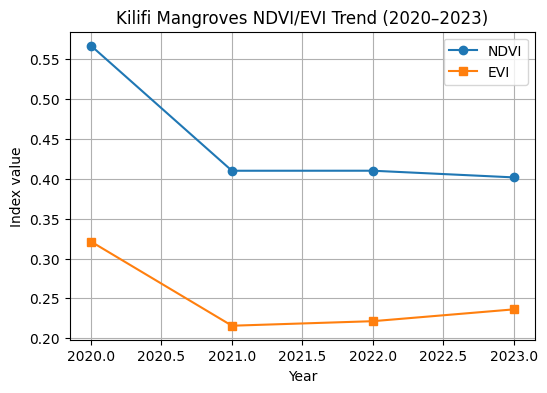

In [12]:
import pandas as pd

data = [f['properties'] for f in trend['features']]
df = pd.DataFrame(data)
print(df)

# Plot trend
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(df['year'], df['mean_NDVI'], marker='o', label='NDVI')
plt.plot(df['year'], df['mean_EVI'], marker='s', label='EVI')
plt.xlabel('Year')
plt.ylabel('Index value')
plt.title('Kilifi Mangroves NDVI/EVI Trend (2020–2023)')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Step 8: Mangrove Health Classification with Random Forest

# Feature bands (Landsat spectral + indices)
feature_bands = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7','NDVI','EVI']

# --- 1) Ground truth data (replace with your asset if available) ---
# Example: ground_truth_fc = ee.FeatureCollection('users/your_name/mangrove_health')
# health_label_property = 'condition'

# --- DEMO training data (0=healthy, 1=unhealthy) ---
health_label_property = 'condition'
ground_truth_fc = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point(39.80, -3.62), {health_label_property: 0}),
    ee.Feature(ee.Geometry.Point(39.82, -3.64), {health_label_property: 1}),
    ee.Feature(ee.Geometry.Point(39.84, -3.60), {health_label_property: 0}),
    ee.Feature(ee.Geometry.Point(39.86, -3.66), {health_label_property: 1}),
    ee.Feature(ee.Geometry.Point(39.88, -3.58), {health_label_property: 0}),
])

print("⚠️ Using dummy points — replace with your real mangrove health dataset for accuracy.")

# --- 2) Sample the composite image at training locations ---
samples = composite.sampleRegions(
    collection=ground_truth_fc,
    properties=[health_label_property],
    scale=30
)

# --- 3) Train Random Forest Classifier ---
classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=100,
    seed=42
).train(
    features=samples,
    classProperty=health_label_property,
    inputProperties=feature_bands
)

print("🌲 Random Forest trained.")


⚠️ Using dummy points — replace with your real mangrove health dataset for accuracy.
🌲 Random Forest trained.


In [14]:
# Evaluate classifier using the training data
train_classified = samples.classify(classifier)
em = train_classified.errorMatrix(health_label_property, 'classification')

print("Confusion Matrix:", em.getInfo())
print("Overall Accuracy:", em.accuracy().getInfo())
print("Kappa:", em.kappa().getInfo())


Confusion Matrix: [[1, 0], [0, 2]]
Overall Accuracy: 1
Kappa: 1


In [15]:
# Classify the composite image across Kilifi
classified = composite.select(feature_bands).classify(classifier)

# Visualize
m3 = geemap.Map(center=[-3.63, 39.84], zoom=11)
m3.addLayer(classified, {
    'min': 0, 'max': 1,
    'palette': ['#00EE00', '#FF0000']  # Green=healthy, Red=unhealthy
}, 'Predicted Mangrove Health')
m3.addLayer(composite, {
    'bands': ['SR_B4','SR_B3','SR_B2'],
    'min': 0, 'max': 0.3
}, 'Landsat RGB (2020–2023)')
m3


Map(center=[-3.63, 39.84], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [16]:
# Step 11: Export classified image

# Export to Google Drive as GeoTIFF
task = ee.batch.Export.image.toDrive(
    image=classified,
    description='kilifi_mangrove_health_2020_2023',
    folder='GEE_Exports',
    fileNamePrefix='kilifi_mangrove_health',
    region=kilifi_geometry,
    scale=30,
    maxPixels=1e13
)
task.start()

print("📤 Export started. Check your Google Drive > GEE_Exports folder.")

# Optional: Export as EE asset (if you want to host/share directly in Earth Engine)
# task2 = ee.batch.Export.image.toAsset(
#     image=classified,
#     description='kilifi_mangrove_health_asset',
#     assetId='users/<your_username>/kilifi_mangrove_health_2020_2023',
#     region=kilifi_geometry,
#     scale=30,
#     maxPixels=1e13
# )
# task2.start()
# print("📦 Export to EE Asset started.")


📤 Export started. Check your Google Drive > GEE_Exports folder.
